In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
from sentence_transformers import SentenceTransformer

d:\Study Material\Extra\EmotionDetection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
df = pd.read_csv('Data\emotion_dataset_raw.csv')
df.dropna(inplace=True)
df['Clean_Text'] = df['Text'].apply(nfx.remove_userhandles)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_punctuations)
print("Shape =", df.shape)
print(df['Emotion'].value_counts())

Shape = (34792, 3)
Emotion
joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: count, dtype: int64


C:\Users\Srajan\AppData\Local\Temp\ipykernel_23996\3795666912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


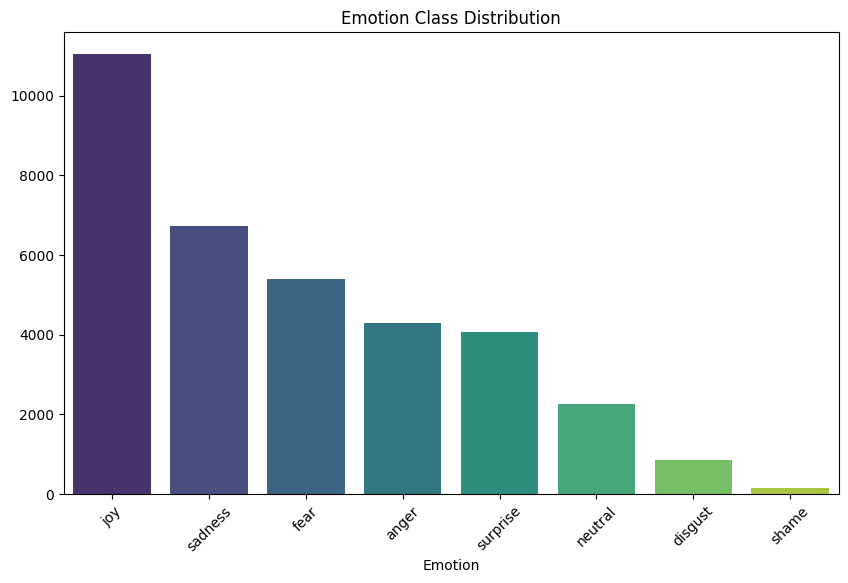

In [3]:
emotion_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title("Emotion Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [4]:
X=df['Clean_Text']
y=df['Emotion']

emb_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') 
x_emb = emb_model.encode(X)

In [6]:
sm=SMOTE(random_state=42)
X_bal,y_bal=sm.fit_resample(x_emb, y)

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X_bal,y_bal,test_size=0.2,random_state=42)

## Using Logistic Model

In [8]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=3000,solver='liblinear')
model.fit(X_train,y_train)

LogisticRegression(max_iter=3000, solver='liblinear')

In [9]:
y_pred=model.predict(X_test)
print("Accuracy:",round(accuracy_score(y_test, y_pred),4)*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 68.14

Classification Report:
               precision    recall  f1-score   support

       anger       0.61      0.58      0.59      2203
     disgust       0.64      0.73      0.68      2191
        fear       0.68      0.63      0.66      2317
         joy       0.53      0.52      0.52      2186
     neutral       0.85      0.86      0.86      2166
     sadness       0.57      0.54      0.55      2185
       shame       0.97      1.00      0.98      2201
    surprise       0.59      0.59      0.59      2223

    accuracy                           0.68     17672
   macro avg       0.68      0.68      0.68     17672
weighted avg       0.68      0.68      0.68     17672



## Using SVM Model

In [10]:
from sklearn.svm import SVC
svm_model=SVC(kernel='linear', C=1)
svm_model.fit(X_train,y_train)

SVC(C=1, kernel='linear')

In [11]:
y_pred=svm_model.predict(X_test)
print("Accuracy:",round(accuracy_score(y_test, y_pred),4)*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 70.09

Classification Report:
               precision    recall  f1-score   support

       anger       0.61      0.63      0.62      2203
     disgust       0.68      0.78      0.72      2191
        fear       0.70      0.65      0.67      2317
         joy       0.54      0.53      0.53      2186
     neutral       0.85      0.87      0.86      2166
     sadness       0.60      0.55      0.57      2185
       shame       0.99      1.00      1.00      2201
    surprise       0.62      0.61      0.62      2223

    accuracy                           0.70     17672
   macro avg       0.70      0.70      0.70     17672
weighted avg       0.70      0.70      0.70     17672



## Using Random Forest Model

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4) * 100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 87.35000000000001

Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.88      0.87      2203
     disgust       0.94      0.99      0.97      2191
        fear       0.91      0.85      0.88      2317
         joy       0.68      0.69      0.68      2186
     neutral       0.95      0.96      0.95      2166
     sadness       0.79      0.76      0.77      2185
       shame       1.00      1.00      1.00      2201
    surprise       0.85      0.87      0.86      2223

    accuracy                           0.87     17672
   macro avg       0.87      0.87      0.87     17672
weighted avg       0.87      0.87      0.87     17672



Since RANDOM FOREST MODEL out-performs other models in terms of accuracy and recall, Therefore it is selected for the Emotion detection task

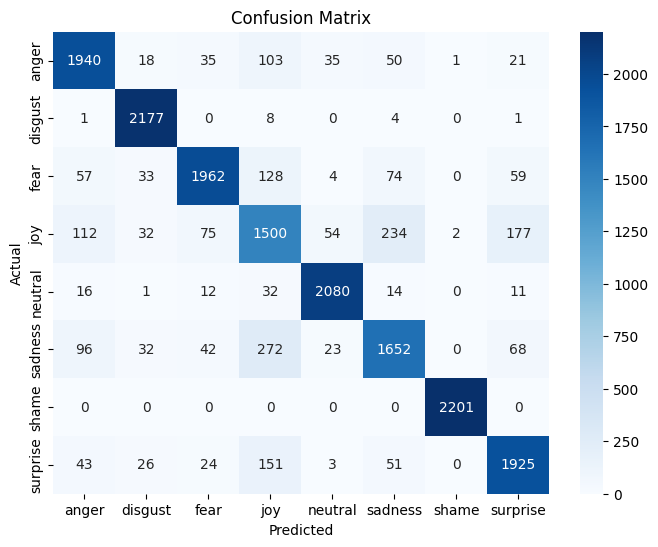

In [13]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
joblib.dump(rf_model,'rf_emotion_model.pkl')
joblib.dump(emb_model,'rf_vectorizer.pkl')

['rf_vectorizer.pkl']

In [19]:
def predict_emotion(text):
    text=nfx.remove_userhandles(text)
    text=nfx.remove_stopwords(text)
    text=nfx.remove_punctuations(text)
    vect_text=emb_model.encode(text).reshape(1, -1)
    return rf_model.predict(vect_text)[0]

#examples
print(predict_emotion("Nobody doubted him , or failed to recognise his temporary financial embarrassment .")) #shame
print(predict_emotion("pop out &amp; roll across the floor !")) #surprise
print(predict_emotion("Why ?")) #neutral

shame
surprise
neutral
